Import libraries

In [13]:
import pandas as pd
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np
from catboost import Pool
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Exploratory Analysis

We will do the analysis based on the idea that women and children were given priority to board the lifeboats.

In [28]:
df = pd.read_csv('train.csv', index_col=0)
df.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


We will deduce the passengers gender based on the title in their names. 

In [32]:
# Extract titles from the 'Name' column
df['Title'] = df['Name'].apply(lambda x: x.split(",")[1].split(".")[0].strip())
df.value_counts("Title")

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
dtype: int64

In [33]:
# Replace titles with general categories
df['Title'] = df['Title'].replace({
    "Capt": "man", "Don": "man", "Major": "man", "Col": "man", 
    "Rev": "man", "Dr": "man", "Sir": "man", "Mr": "man", "Jonkheer": "man",
    "Dona": "woman", "the Countess": "woman", "Mme": "woman", 
    "Mlle": "woman", "Ms": "woman", "Miss": "woman", "Lady": "woman", "Mrs": "woman",
    "Master": "boy"
})
df.value_counts("Title")

Title
man      538
woman    313
boy       40
dtype: int64

We will group people 

In [34]:
# Extract surnames from the 'Name' column
df['Surname'] = df['Name'].apply(lambda x: x.split(",")[0])
df.value_counts("Surname")

Surname
Andersson        9
Sage             7
Skoog            6
Carter           6
Goodwin          6
                ..
Henry            1
Hewlett          1
Hirvonen         1
Hodges           1
van Melkebeke    1
Length: 667, dtype: int64

In [35]:
# Group 'man' titles under 'noGroup'
df.loc[df['Title'] == 'man', 'Surname'] = 'noGroup'

# Calculate the frequency of surnames
df['SurnameFreq'] = df.groupby('Surname')['Surname'].transform('count')

# Group surnames that appear only once under 'noGroup'
df.loc[df['SurnameFreq'] <= 1, 'Surname'] = 'noGroup'

# Calculate the survival rates for 'woman-child-groups'
df['SurnameSurvival'] = df.groupby('Surname')['Survived'].transform('mean')

In [36]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,SurnameFreq,SurnameSurvival
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,man,noGroup,538,0.34713
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,woman,noGroup,1,0.34713
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,woman,noGroup,1,0.34713
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,woman,noGroup,1,0.34713
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,man,noGroup,538,0.34713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,man,noGroup,538,0.34713
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,woman,Graham,2,1.00000
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,woman,noGroup,1,0.34713


In [37]:
# Adjust survival rates for use on the training set
df['AdjustedSurvival'] = (df['SurnameSurvival'] * df['SurnameFreq'] - df['Survived']) / (df['SurnameFreq'] - 1)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,SurnameFreq,SurnameSurvival,AdjustedSurvival
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,man,noGroup,538,0.34713,0.347776
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,woman,noGroup,1,0.34713,-inf
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,woman,noGroup,1,0.34713,-inf
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,woman,noGroup,1,0.34713,-inf
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,man,noGroup,538,0.34713,0.347776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,man,noGroup,538,0.34713,0.347776
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,woman,Graham,2,1.00000,1.000000
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,woman,noGroup,1,0.34713,inf


In [38]:
# Apply gender model plus new predictor to the dataing set
df['predict'] = 0
df.loc[df['Title'] == 'woman', 'predict'] = 1
df.loc[(df['Title'] == 'boy') & (df['AdjustedSurvival'] == 1), 'predict'] = 1
df.loc[(df['Title'] == 'woman') & (df['AdjustedSurvival'] == 0), 'predict'] = 0
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,SurnameFreq,SurnameSurvival,AdjustedSurvival,predict
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,man,noGroup,538,0.34713,0.347776,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,woman,noGroup,1,0.34713,-inf,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,woman,noGroup,1,0.34713,-inf,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,woman,noGroup,1,0.34713,-inf,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,man,noGroup,538,0.34713,0.347776,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,man,noGroup,538,0.34713,0.347776,0
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,woman,Graham,2,1.00000,1.000000,1
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,woman,noGroup,1,0.34713,inf,1


ETL

In [14]:
def preprocess_data(data):

    # Extract titles from the 'Name' column
    data['Title'] = data['Name'].apply(lambda x: x.split(",")[1].split(".")[0].strip())

    # Replace titles with general categories
    data['Title'] = data['Title'].replace({
        "Capt": "man", "Don": "man", "Major": "man", "Col": "man", 
        "Rev": "man", "Dr": "man", "Sir": "man", "Mr": "man", "Jonkheer": "man",
        "Dona": "woman", "the Countess": "woman", "Mme": "woman", 
        "Mlle": "woman", "Ms": "woman", "Miss": "woman", "Lady": "woman", "Mrs": "woman",
        "Master": "boy"
    })

    # Extract surnames from the 'Name' column
    data['Surname'] = data['Name'].apply(lambda x: x.split(",")[0])

    # Group 'man' titles under 'noGroup'
    data.loc[data['Title'] == 'man', 'Surname'] = 'noGroup'

    # Calculate the frequency of surnames
    data['SurnameFreq'] = data.groupby('Surname')['Surname'].transform('count')

    # Group surnames that appear only once under 'noGroup'
    data.loc[data['SurnameFreq'] <= 1, 'Surname'] = 'noGroup'

    # Calculate the survival rates for 'woman-child-groups'
    data['SurnameSurvival'] = data.groupby('Surname')['Survived'].transform('mean')

    # Adjust survival rates for use on the training set
    data['AdjustedSurvival'] = (data['SurnameSurvival'] * data['SurnameFreq'] - data['Survived']) / (data['SurnameFreq'] - 1)

    # Apply gender model plus new predictor to the dataing set
    data['predict'] = 0
    data.loc[data['Title'] == 'woman', 'predict'] = 1
    data.loc[(data['Title'] == 'boy') & (data['AdjustedSurvival'] == 1), 'predict'] = 1
    data.loc[(data['Title'] == 'woman') & (data['AdjustedSurvival'] == 0), 'predict'] = 0


    data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0})
    data = pd.get_dummies(data, columns=['Embarked'])
    return data

In [15]:
train = pd.read_csv("train.csv", index_col=0)
train = preprocess_data(train)

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)

len(X_train), len(y_train)

(891, 891)

In [16]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Surname,SurnameFreq,SurnameSurvival,AdjustedSurvival,predict,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
1,3,0,22.0,1,0,7.2500,man,noGroup,538,0.34713,0.347776,0,0,0,1
2,1,1,38.0,1,0,71.2833,woman,noGroup,1,0.34713,-inf,1,1,0,0
3,3,1,26.0,0,0,7.9250,woman,noGroup,1,0.34713,-inf,1,0,0,1
4,1,1,35.0,1,0,53.1000,woman,noGroup,1,0.34713,-inf,1,0,0,1
5,3,0,35.0,0,0,8.0500,man,noGroup,538,0.34713,0.347776,0,0,0,1


In [17]:
test = pd.read_csv('test_with_survived.csv', index_col=0)
test = preprocess_data(test)

y_test = test['Survived']
X_test = test.drop(["Survived"], axis=1)

len(X_test), len(y_test)

(418, 418)

In [18]:
cat_features = np.where(X_train.dtypes != float)[0]
cat_features

array([ 0,  1,  3,  4,  6,  7,  8, 11, 12, 13, 14], dtype=int64)

In [19]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title,Surname,SurnameFreq,SurnameSurvival,AdjustedSurvival,predict,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
1,3,0,22.0,1,0,7.2500,man,noGroup,538,0.34713,0.347776,0,0,0,1
2,1,1,38.0,1,0,71.2833,woman,noGroup,1,0.34713,-inf,1,1,0,0
3,3,1,26.0,0,0,7.9250,woman,noGroup,1,0.34713,-inf,1,0,0,1
4,1,1,35.0,1,0,53.1000,woman,noGroup,1,0.34713,-inf,1,0,0,1
5,3,0,35.0,0,0,8.0500,man,noGroup,538,0.34713,0.347776,0,0,0,1


Create a Model

In [21]:
# fit the model
model = CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', verbose=False, use_best_model=True, random_seed=42, cat_features=cat_features)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# make predictions
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
accuracy # 0.7990430622009569

0.8947368421052632

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       260
           1       1.00      0.72      0.84       158

    accuracy                           0.89       418
   macro avg       0.93      0.86      0.88       418
weighted avg       0.91      0.89      0.89       418



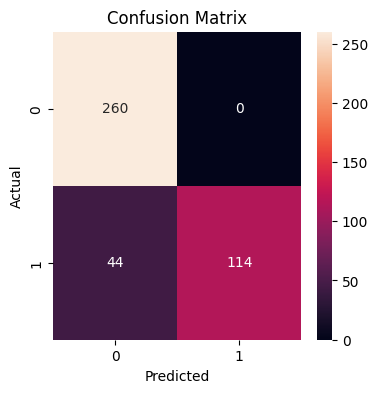

In [23]:
plt.figure(figsize = (4,4))
cm = sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True)
cm.set(title='Confusion Matrix')
cm.set(xlabel='Predicted', ylabel='Actual')
plt.show()

In [39]:
# get the feature importance
feature_importance = model.get_feature_importance(prettified=True)
feature_importance

,Feature Id,Importances
0,AdjustedSurvival,72.625417
1,SurnameFreq,14.359487
2,SurnameSurvival,8.099007
3,Fare,1.403402
4,predict,1.031117
5,Title,0.802247
6,Pclass,0.595325
7,SibSp,0.390463
8,Age,0.280797
9,Surname,0.170514


Hyperparameter Tuning

We are going to find the best parameters for the model using GridSearchCV. Also, we are going to use Cross Validation to avoid overfitting.

In [24]:
'''
cat_for_search = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='Accuracy',
                                    verbose=False,
                                    random_state=42)

params = {'depth': [2,3,4,5,6,7,8,9,10]}

'''
params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
}
'''

grid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)

best_model = CatBoostClassifier(depth=grid['params']['depth'],
                                loss_function='Logloss',
                                eval_metric='Accuracy',
                                use_best_model=True,
                                random_seed=42,
                                verbose=False)

best_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))

accuracy_score(y_test, best_model.predict(X_test))
'''

"\n\ngrid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)\n\nbest_model = CatBoostClassifier(depth=grid['params']['depth'],\n                                loss_function='Logloss',\n                                eval_metric='Accuracy',\n                                use_best_model=True,\n                                random_seed=42,\n                                verbose=False)\n\nbest_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))\n\naccuracy_score(y_test, best_model.predict(X_test))\n"